In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
import os


In [2]:
final_data = pd.read_csv("final_data_price_news.csv",parse_dates=["Adjusted_Date"])

In [3]:
final_data.drop(columns=['Unnamed: 0'],errors='ignore', inplace=True)

In [4]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1605 entries, 0 to 1604
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Stock_Name      1605 non-null   object        
 1   Adjusted_Date   1605 non-null   datetime64[ns]
 2   Open            1605 non-null   float64       
 3   High            1605 non-null   float64       
 4   Low             1605 non-null   float64       
 5   Close           1605 non-null   float64       
 6   Volume          1605 non-null   int64         
 7   Dividends       1605 non-null   float64       
 8   Stock Splits    1605 non-null   float64       
 9   Label           1605 non-null   int64         
 10  negative_score  1605 non-null   float64       
 11  neutral_score   1605 non-null   float64       
 12  positive_score  1605 non-null   float64       
dtypes: datetime64[ns](1), float64(9), int64(2), object(1)
memory usage: 163.1+ KB


In [5]:
valid_stock_names = final_data["Stock_Name"].value_counts()
valid_stock_names = valid_stock_names[valid_stock_names > 3].index

# Filter the DataFrame to include only valid stock names
final_data = final_data[final_data["Stock_Name"].isin(valid_stock_names)]

# Display the updated value counts to verify
print(final_data["Stock_Name"].value_counts())

Stock_Name
LUPIN.NS         82
TATAPOWER.NS     79
HDFCBANK.NS      78
ITC.NS           77
IRCTC.NS         77
INFY.NS          74
SBIN.NS          73
TITAN.NS         73
STARHEALTH.NS    72
VEDL.NS          72
ONGC.NS          71
ASIANPAINT.NS    70
LICI.NS          69
TCS.NS           67
COCHINSHIP.NS    67
PAYTM.NS         67
RELIANCE.NS      67
ZOMATO.NS        66
ADANIENT.NS      65
TECHM.NS         62
AUROPHARMA.NS    57
DMART.NS         55
HYUNDAI.NS       45
NTPCGREEN.NS     20
Name: count, dtype: int64


In [6]:

def split_time_series_data(data, data_set_1_size=0.8):
    # Step 1: Group by Stock_Name
    grouped = data.groupby("Stock_Name")

    # Step 2: Create empty lists to hold train and test data
    train_data = []
    test_data = []

    # Step 3: Loop through each stock group
    for stock_name, group in grouped:
        # Step 4: Sort the data by Date (ascending order)
        group = group.sort_values("Adjusted_Date")

        # Step 5: Split into 80% train and 20% test
        train_size = int(len(group) * 0.8)  # 80% of the data

        # The train and test datasets for this stock
        stock_train = group[:train_size]
        stock_test = group[train_size:]

        # Append to the train and test lists
        train_data.append(stock_train)
        test_data.append(stock_test)

    # Step 6: Concatenate all train and test data back into single DataFrames
    train_data = pd.concat(train_data, axis=0)
    test_data = pd.concat(test_data, axis=0)

    # Step 7: (Optional) Reset index for train and test datasets
    train_data = train_data.reset_index(drop=True)
    test_data = test_data.reset_index(drop=True)

    return train_data, test_data

In [7]:
train_data , test_data = split_time_series_data(final_data)

print(f"train data shape {train_data.shape}")
print(f"test data shape {test_data.shape}")

train data shape (1274, 13)
test data shape (331, 13)


In [8]:
all_counts = final_data['Stock_Name'].value_counts().reset_index()
train_counts = train_data['Stock_Name'].value_counts().reset_index()
test_counts = test_data['Stock_Name'].value_counts().reset_index()

# Rename columns for better clarity
all_counts.columns = ['Stock_Name','Total_count']
train_counts.columns = ['Stock_Name', 'Train_Count']
test_counts.columns = ['Stock_Name', 'Test_Count']

# Merge the first two DataFrames
stock_counts = pd.merge(all_counts, train_counts, on='Stock_Name', how='outer')

# Merge the result with the third DataFrame
stock_counts = pd.merge(stock_counts, test_counts, on='Stock_Name', how='outer')

# Print the result in tabular format
stock_counts

,Stock_Name,Total_count,Train_Count,Test_Count
0,ADANIENT.NS,65,52,13
1,ASIANPAINT.NS,70,56,14
2,AUROPHARMA.NS,57,45,12
3,COCHINSHIP.NS,67,53,14
4,DMART.NS,55,44,11
5,HDFCBANK.NS,78,62,16
6,HYUNDAI.NS,45,36,9
7,INFY.NS,74,59,15
8,IRCTC.NS,77,61,16
9,ITC.NS,77,61,16


In [9]:
train_data.head()

,Stock_Name,Adjusted_Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Label,negative_score,neutral_score,positive_score
0,ADANIENT.NS,2024-09-02,3021.100098,3059.149902,2997.600098,3042.149902,1842658,0.0,0.0,-1,0.992560,0.004107,0.003333
1,ADANIENT.NS,2024-09-03,3037.000000,3053.050049,3023.800049,3036.100098,1371577,0.0,0.0,-1,0.972357,0.023498,0.004145
2,ADANIENT.NS,2024-09-04,3010.000000,3025.000000,2955.199951,3012.350098,1212270,0.0,0.0,1,0.991823,0.005121,0.003057
3,ADANIENT.NS,2024-09-05,3025.000000,3037.899902,3002.000000,3015.350098,734273,0.0,0.0,1,0.731447,0.252796,0.015757
4,ADANIENT.NS,2024-09-06,3019.000000,3025.000000,2968.000000,2975.449951,1251165,0.0,0.0,-1,0.991486,0.005457,0.003058


In [10]:
test_data.head(10)

,Stock_Name,Adjusted_Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Label,negative_score,neutral_score,positive_score
0,ADANIENT.NS,2024-12-12,2457.000000,2534.800049,2446.250000,2504.100098,2579624,0.0,0.0,1,0.990830,0.006196,0.002974
1,ADANIENT.NS,2024-12-13,2504.000000,2545.000000,2479.050049,2527.550049,1940935,0.0,0.0,1,0.985375,0.011183,0.003442
2,ADANIENT.NS,2024-12-16,2530.000000,2537.500000,2503.000000,2512.399902,654321,0.0,0.0,-1,0.858586,0.129195,0.012219
3,ADANIENT.NS,2024-12-17,2512.000000,2525.000000,2480.750000,2487.600098,1061891,0.0,0.0,-1,0.989909,0.006657,0.003434
4,ADANIENT.NS,2024-12-18,2489.000000,2496.600098,2452.000000,2457.399902,990217,0.0,0.0,-1,0.974408,0.020960,0.004632
5,ADANIENT.NS,2024-12-19,2429.000000,2434.000000,2397.100098,2419.350098,1181898,0.0,0.0,1,0.991128,0.005801,0.003071
6,ADANIENT.NS,2024-12-20,2429.000000,2453.850098,2333.000000,2344.949951,1337016,0.0,0.0,1,0.990663,0.006402,0.002935
7,ADANIENT.NS,2024-12-23,2373.949951,2379.500000,2332.750000,2338.949951,758920,0.0,0.0,1,0.990979,0.005592,0.003429
8,ADANIENT.NS,2024-12-26,2378.050049,2410.000000,2368.000000,2400.250000,895785,0.0,0.0,1,0.075033,0.863305,0.061662
9,ADANIENT.NS,2024-12-27,2415.000000,2446.149902,2390.500000,2409.949951,1982291,0.0,0.0,1,0.988380,0.008048,0.003571


In [11]:
X_train = train_data.drop(['Stock_Name', 'Adjusted_Date','Label','Close'], axis=1)
y_train = train_data['Close']

X_test = test_data.drop(['Stock_Name', 'Adjusted_Date','Label','Close'], axis=1)
y_test = test_data['Close']

In [12]:
print(f"X_train shape {X_train.shape}")
print(f"y_train shape {y_train.shape}")

print(f"X_test shape {X_test.shape}")
print(f"y_test shape {y_test.shape}")

X_train shape (1274, 9)
y_train shape (1274,)
X_test shape (331, 9)
y_test shape (331,)


In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Define models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "SVR": SVR(kernel='rbf'),
    "XGBoost": XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
}

# Dictionary to store results
results = {}

# Train and evaluate each model
for model_name, model in models.items():
    print(f"Training {model_name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Compute evaluation metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    results[model_name] = {
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse,
        "R-Squared": r2
    }

    print(f"{model_name} - MAE: {mae:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}, R2: {r2:.4f}\n")

# Convert results to DataFrame for better visualization
import pandas as pd
results_df = pd.DataFrame(results).T
print(results_df)


Training Linear Regression...
Linear Regression - MAE: 6.6389, MSE: 123.5169, RMSE: 11.1138, R2: 0.9999

Training Random Forest...
Random Forest - MAE: 11.1855, MSE: 331.6239, RMSE: 18.2105, R2: 0.9997

Training SVR...
SVR - MAE: 842.4261, MSE: 1102815.7595, RMSE: 1050.1504, R2: 0.0495

Training XGBoost...
XGBoost - MAE: 17.6024, MSE: 921.9689, RMSE: 30.3639, R2: 0.9992

                          MAE           MSE         RMSE  R-Squared
Linear Regression    6.638907  1.235169e+02    11.113817   0.999894
Random Forest       11.185512  3.316239e+02    18.210543   0.999714
SVR                842.426125  1.102816e+06  1050.150351   0.049508
XGBoost             17.602441  9.219689e+02    30.363941   0.999205


### Observations:
1. Linear Regression performs the best, with the lowest MSE (123.51) and the highest R² (0.9999).
2. Random Forest is slightly worse than Linear Regression but still very strong (MSE: 331.62, R²: 0.9997).
3. XGBoost performs well but is not as good as Linear Regression (MSE: 921.96, R²: 0.9992).
4. SVR is completely failing with R² = 0.0495, meaning it barely explains any variance in the target variable.

In [14]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Define parameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [50, 100, 200],  # Number of trees
    'max_depth': [10, 20, 30, None],  # Maximum depth of trees
    'min_samples_split': [2, 5, 10],  # Minimum samples to split a node
    'min_samples_leaf': [1, 2, 4],  # Minimum samples at a leaf node
    'max_features': ['sqrt', 'log2'],  # Number of features to consider
}

# Initialize GridSearchCV
rf_grid = GridSearchCV(RandomForestRegressor(random_state=42), param_grid_rf,
                       scoring='r2', cv=5, n_jobs=-1, verbose=2)

# Fit GridSearchCV
rf_grid.fit(X_train, y_train)

# Best model and parameters
best_rf = rf_grid.best_estimator_
print("Best Random Forest Parameters:", rf_grid.best_params_)

# Evaluate on test set
y_pred_rf = best_rf.predict(X_test)
rf_r2 = r2_score(y_test, y_pred_rf)
print(f"Optimized Random Forest R2 Score: {rf_r2:.4f}")


Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best Random Forest Parameters: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Optimized Random Forest R2 Score: 0.9995


In [15]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

# Define parameter grid for XGBoost
param_grid_xgb = {
    'n_estimators': [50, 100, 200],  # Number of boosting rounds
    'learning_rate': [0.01, 0.05, 0.1, 0.2],  # Step size shrinkage
    'max_depth': [3, 5, 7, 10],  # Maximum depth of trees
    'min_child_weight': [1, 3, 5],  # Minimum sum of instance weight needed in a child
    'subsample': [0.7, 0.8, 1.0],  # Fraction of samples used for training
    'colsample_bytree': [0.7, 0.8, 1.0]  # Fraction of features used for each tree
}

# Initialize GridSearchCV
xgb_grid = GridSearchCV(XGBRegressor(random_state=42), param_grid_xgb,
                        scoring='r2', cv=5, n_jobs=-1, verbose=2)

# Fit GridSearchCV
xgb_grid.fit(X_train, y_train)

# Best model and parameters
best_xgb = xgb_grid.best_estimator_
print("Best XGBoost Parameters:", xgb_grid.best_params_)

# Evaluate on test set
y_pred_xgb = best_xgb.predict(X_test)
xgb_r2 = r2_score(y_test, y_pred_xgb)
print(f"Optimized XGBoost R2 Score: {xgb_r2:.4f}")


Fitting 5 folds for each of 1296 candidates, totalling 6480 fits
Best XGBoost Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 10, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.7}
Optimized XGBoost R2 Score: 0.9992


In [ ]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Initialize XGBoost Regressor
xgb = XGBRegressor(random_state=42)

# Perform GridSearchCV
grid_search = GridSearchCV(xgb, param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Best parameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Train best model
best_xgb = XGBRegressor(**best_params, random_state=42)
best_xgb.fit(X_train, y_train)

# Predict and evaluate
y_pred = best_xgb.predict(X_test)

# Compute evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Tuned XGBoost - MAE: {mae:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}, R2: {r2:.4f}")


In [16]:
import pickle

with open('best_model_regression.pkl', 'wb') as f:
    pickle.dump(best_rf, f)

print("Best model saved to best_model_regression.pkl")

Best model saved to best_model_regression.pkl


X_seq_train shape: (1263, 10, 6), y_seq_train shape: (1263, 1)
X_seq_test shape: (320, 10, 6), y_seq_test shape: (320, 1)
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 1.1408 - val_loss: 0.0457
Epoch 2/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.5802 - val_loss: 0.0367
Epoch 3/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.4641 - val_loss: 0.0560
Epoch 4/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.4146 - val_loss: 0.0578
Epoch 5/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.3275 - val_loss: 0.0402
Epoch 6/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.3117 - val_loss: 0.0278
Epoch 7/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.3020 - val_loss: 0.0395
Epoch 8/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.2498 - val_loss: 0.0279
Epoch 9/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.2468 - val_loss: 0.0221
Epoch 10/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.2002 - val_loss: 0.0288
Epoch 11/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.1834 - val_loss: 0.0248
Epoch 12/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1721 - val_l

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 10, 128)             │          69,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 10, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 10, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 357,317 (1.36 MB)

 Trainable params: 118,977 (464.75 KB)

 Non-trainable params: 384 (1.50 KB)

 Optimizer params: 237,956 (929.52 KB)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


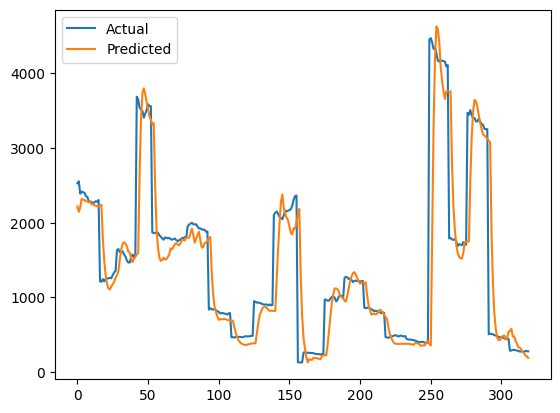

LSTM Model - MAE: 280.6009, MSE: 359090.2744, RMSE: 599.2414, R2: 0.6921


In [13]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

train_data_lstm, test_data_lstm = split_time_series_data(final_data)

# Prepare X and y
features = ['Open', 'High', 'Low', 'negative_score', 'neutral_score', 'positive_score']
X_train, y_train = train_data_lstm[features].values, train_data_lstm['Close'].shift(-1).values[:-1]
X_test, y_test = test_data_lstm[features].values, test_data_lstm['Close'].shift(-1).values[:-1]

# Scale Data
scaler_X = MinMaxScaler()
X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)

scaler_y = MinMaxScaler()
y_train = scaler_y.fit_transform(y_train.reshape(-1, 1))
y_test = scaler_y.transform(y_test.reshape(-1, 1))

# Convert to time-series format
sequence_length = 10
X_seq_train, y_seq_train, X_seq_test, y_seq_test = [], [], [], []

# Loop for X_train and y_train
for i in range(len(X_train) - sequence_length):
    X_seq_train.append(X_train[i:i + sequence_length])
    # Ensure that we have a valid index for y_train[i + sequence_length]
    if i + sequence_length < len(y_train):
        y_seq_train.append(y_train[i + sequence_length])  # Add corresponding y value (next day's 'Close')

# Convert to numpy arrays after loop
X_seq_train = np.array(X_seq_train)
y_seq_train = np.array(y_seq_train)

# Make sure both X_seq_train and y_seq_train have the same number of samples
min_length = min(X_seq_train.shape[0], y_seq_train.shape[0])  # Find the smaller length
X_seq_train = X_seq_train[:min_length]
y_seq_train = y_seq_train[:min_length]

# Loop for X_test and y_test
for i in range(len(X_test) - sequence_length):
    X_seq_test.append(X_test[i:i + sequence_length])
    # Ensure that we have a valid index for y_test[i + sequence_length]
    if i + sequence_length < len(y_test):
        y_seq_test.append(y_test[i + sequence_length])  # Add corresponding y value (next day's 'Close')

# Convert to numpy arrays after loop
X_seq_test = np.array(X_seq_test)
y_seq_test = np.array(y_seq_test)

# Make sure both X_seq_test and y_seq_test have the same number of samples
min_length_test = min(X_seq_test.shape[0], y_seq_test.shape[0])  # Find the smaller length
X_seq_test = X_seq_test[:min_length_test]
y_seq_test = y_seq_test[:min_length_test]

# Check that both X and y have the same length
print(f"X_seq_train shape: {X_seq_train.shape}, y_seq_train shape: {y_seq_train.shape}")
print(f"X_seq_test shape: {X_seq_test.shape}, y_seq_test shape: {y_seq_test.shape}")

# Define LSTM model
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(sequence_length, X_seq_train.shape[2])),
    BatchNormalization(),
    Dropout(0.2),
    LSTM(64, return_sequences=False),
    BatchNormalization(),
    Dropout(0.2),
    Dense(1)
])

# Compile model
optimizer = Adam(learning_rate=0.0005, clipvalue=1.0)
model.compile(optimizer=optimizer, loss='mse')

# Train model
model.fit(X_seq_train, y_seq_train, epochs=50, batch_size=16, validation_data=(X_seq_test, y_seq_test))

model.summary()

# Predictions
y_pred = model.predict(X_seq_test)

# Rescale predictions
y_pred_rescaled = scaler_y.inverse_transform(y_pred)
y_test_rescaled = scaler_y.inverse_transform(y_seq_test)

# Plot Results
plt.plot(y_test_rescaled, label='Actual')
plt.plot(y_pred_rescaled, label='Predicted')
plt.legend()
plt.show()

# Evaluation Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_rescaled, y_pred_rescaled)

print(f"LSTM Model - MAE: {mae:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}, R2: {r2:.4f}")


In [14]:
pip install torch transformers sklearn matplotlib

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


Epoch [1/100], Loss: 0.0388, LR: 0.000500
Epoch [2/100], Loss: 0.0106, LR: 0.000500
Epoch [3/100], Loss: 0.0086, LR: 0.000500
Epoch [4/100], Loss: 0.0076, LR: 0.000500
Epoch [5/100], Loss: 0.0072, LR: 0.000500
Epoch [6/100], Loss: 0.0067, LR: 0.000500
Epoch [7/100], Loss: 0.0067, LR: 0.000500
Epoch [8/100], Loss: 0.0060, LR: 0.000500
Epoch [9/100], Loss: 0.0057, LR: 0.000500
Epoch [10/100], Loss: 0.0058, LR: 0.000500
Epoch [11/100], Loss: 0.0056, LR: 0.000500
Epoch [12/100], Loss: 0.0052, LR: 0.000500
Epoch [13/100], Loss: 0.0052, LR: 0.000500
Epoch [14/100], Loss: 0.0055, LR: 0.000500
Epoch [15/100], Loss: 0.0052, LR: 0.000500
Epoch [16/100], Loss: 0.0051, LR: 0.000500
Epoch [17/100], Loss: 0.0049, LR: 0.000500
Epoch [18/100], Loss: 0.0047, LR: 0.000500
Epoch [19/100], Loss: 0.0047, LR: 0.000500
Epoch [20/100], Loss: 0.0046, LR: 0.000500
Epoch [21/100], Loss: 0.0046, LR: 0.000500
Epoch [22/100], Loss: 0.0053, LR: 0.000500
Epoch [23/100], Loss: 0.0045, LR: 0.000500
Epoch [24/100], Loss

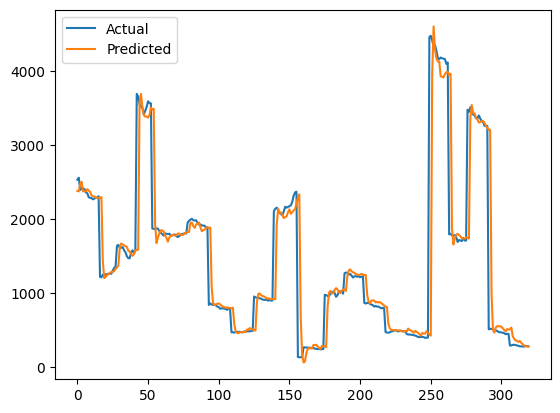

In [15]:
import numpy as np
import pandas as pd
import torch
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import matplotlib.pyplot as plt
import torch.nn as nn

train_data_lstm2, test_data_lstm2 = split_time_series_data(final_data)

# Prepare X and y (using sentiment and other features)
features = ['Open', 'High', 'Low', 'negative_score', 'neutral_score', 'positive_score']
X_train, y_train = train_data_lstm2[features].iloc[:-1].values, train_data_lstm2['Close'].iloc[1:].values
X_test, y_test = test_data_lstm2[features].iloc[:-1].values, test_data_lstm2['Close'].iloc[1:].values

# Scale Data
scaler_X = MinMaxScaler()
X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)

scaler_y = MinMaxScaler()
y_train = scaler_y.fit_transform(y_train.reshape(-1, 1))
y_test = scaler_y.transform(y_test.reshape(-1, 1))

# Create Time-Series Sequences
sequence_length = 10
X_seq_train, y_seq_train, X_seq_test, y_seq_test = [], [], [], []

# Prepare sequences for training
for i in range(len(X_train) - sequence_length):
    if i + sequence_length < len(y_train):
      X_seq_train.append(X_train[i:i + sequence_length])
      y_seq_train.append(y_train[i + sequence_length])

# Prepare sequences for testing
for i in range(len(X_test) - sequence_length):
    if i + sequence_length < len(y_test):
      X_seq_test.append(X_test[i:i + sequence_length])
      y_seq_test.append(y_test[i + sequence_length])

# Convert to numpy arrays
X_seq_train = np.array(X_seq_train)
y_seq_train = np.array(y_seq_train)
X_seq_test = np.array(X_seq_test)
y_seq_test = np.array(y_seq_test)

# Define Dataset Class for the Time-Series
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = TimeSeriesDataset(X_seq_train, y_seq_train)
test_dataset = TimeSeriesDataset(X_seq_test, y_seq_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define Informer Model
class InformerModel(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_rate=0.2):
        super(InformerModel, self).__init__()
        # self.lstm = torch.nn.LSTM(input_size, hidden_size, batch_first=True)
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True, num_layers=2, dropout=0.2)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = torch.nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.dropout(x[:, -1, :])
        x = self.fc(x)   # Take the last timestep's output
        return x

# Initialize and train model
input_size = X_seq_train.shape[2]
hidden_size = 128
output_size = 1

model = InformerModel(input_size, hidden_size, output_size)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

# Training Loop
epochs = 100
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    scheduler.step(epoch_loss)

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss / len(train_loader):.4f}, LR: {scheduler.get_last_lr()[0]:.6f}")

# Evaluate the model
model.eval()
predictions, actuals = [], []
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        print(f"Batch_X shape: {batch_X.shape}, Batch_y shape: {batch_y.shape}")
        outputs = model(batch_X)
        predictions.append(outputs.numpy()) if outputs.shape[0] > 0 else print("Empty prediction batch!")
        actuals.append(batch_y.numpy()) if batch_y.shape[0] > 0 else print("Empty actual batch!")

predictions = np.concatenate(predictions, axis=0)
actuals = np.concatenate(actuals, axis=0)

# Rescale predictions and actuals
predictions_rescaled = scaler_y.inverse_transform(predictions)
actuals_rescaled = scaler_y.inverse_transform(actuals)

# Metrics
mae = mean_absolute_error(actuals_rescaled, predictions_rescaled)
mse = mean_squared_error(actuals_rescaled, predictions_rescaled)
rmse = np.sqrt(mse)
r2 = r2_score(actuals_rescaled, predictions_rescaled)
mape = np.mean(np.abs((actuals_rescaled - predictions_rescaled) / actuals_rescaled)) * 100

print(f"MAE: {mae:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}, R2: {r2:.4f}, MAPE: {mape:.2f}%")

# Plot Results
plt.plot(actuals_rescaled, label='Actual')
plt.plot(predictions_rescaled, label='Predicted')
plt.legend()
plt.show()


In [16]:
import torch
import pickle

# Save the entire model
torch.save(model, "informer_model_regression.pth")

# Save only model state_dict (recommended)
torch.save(model.state_dict(), "informer_model_regression_state.pth")


In [17]:
with open("preprocessing_lstm_scaler_regression.pkl", "wb") as f:
    pickle.dump({"scaler_X": scaler_X, "scaler_y": scaler_y}, f)

In [18]:
# Save the trained model
torch.save(model.state_dict(), "lstm_model_regression.pkl")
print("Model saved successfully as lstm_model_regression.pkl")


Model saved successfully as lstm_model_regression.pkl
